In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot8DimsNS_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [7]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DDimsNS"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/8DDimsNS/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "MSE" in file and "bwidx" not in file:
                mses = pd.read_parquet(root_nadaraya_dir+file)
                mses["bw"] = [mses["bw"].loc[i][0] for i in mses.index]
                print(mses)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        print(s.split("/")[-1].split("_"))
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [8]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)
len(bws)

            bw           mse
10    0.004538     36.059658
11    0.005992     52.681775
12    0.007912    163.089347
13    0.010446    455.783908
14    0.013793   1010.924740
15    0.018211   1973.957339
16    0.024046   3541.856753
17    0.031749   6697.056607
18    0.041919  12626.495304
19    0.055348  22195.439880
20    0.073079  32780.573884
21    0.096490  36642.864132
22    0.127401  32949.594871
23    0.168214  27025.451374
24    0.222102  19407.326803
25    0.293252  11239.495602
26    0.387196   4619.395655
27    0.511235   1139.292117
28    0.675010    164.158179
29    0.891251     39.861562
30    1.135011     27.742746
31    1.445440     24.844852
32    1.840772     24.676543
33    2.344229     25.775361
34    2.985383     26.530447
35    3.801894     25.594339
36    4.841724     23.125076
37    6.165950     20.360410
38    7.852356     18.170652
39   10.000000     16.712391
40   12.589254     15.848933
41   15.848932     15.320026
42   19.952623     14.997403
43   25.118864

50

Text(0.5, 1.0, 'Minimum MSE is (100.0, 14.494305547237698)')

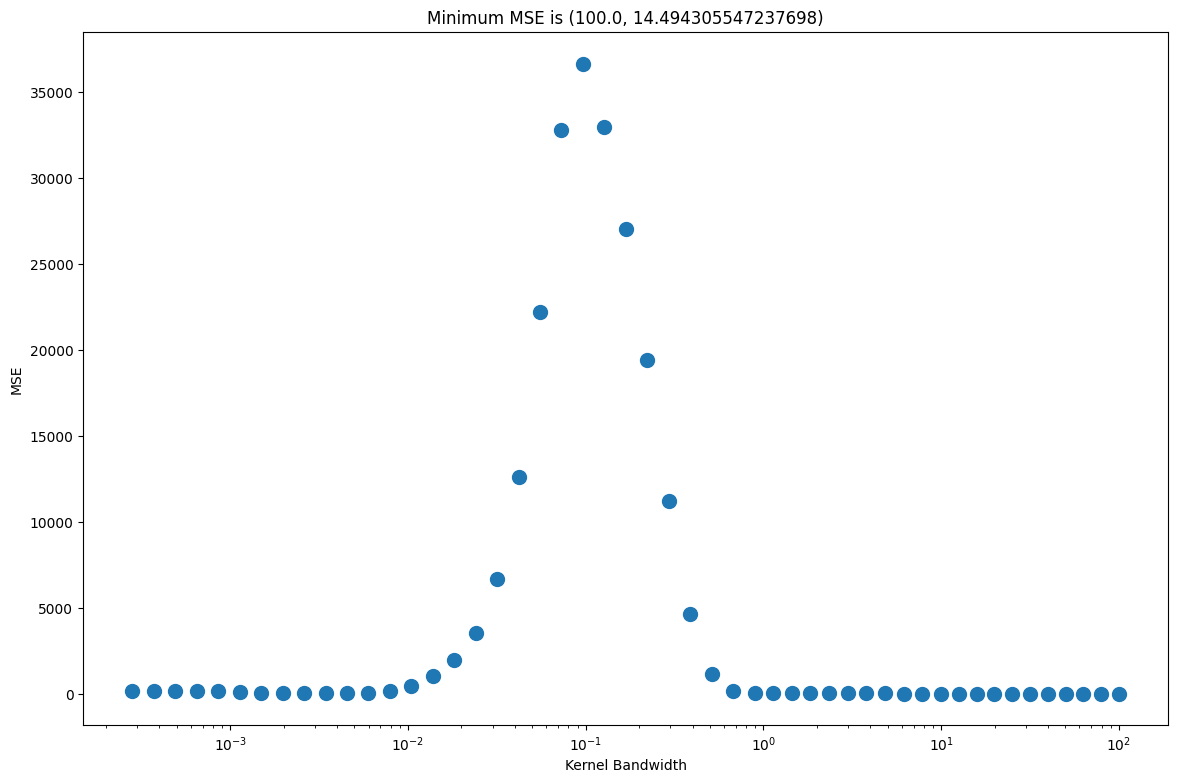

In [9]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 0], mses.iloc[np.argmin(mses.mse), 1]}")

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_5064/3039973056.py:13: RuntimeWarning: divide by zero encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_5064/3039973056.py:14: RuntimeWarning: divide by zero encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


12.30683221527914 0.0007912 inf


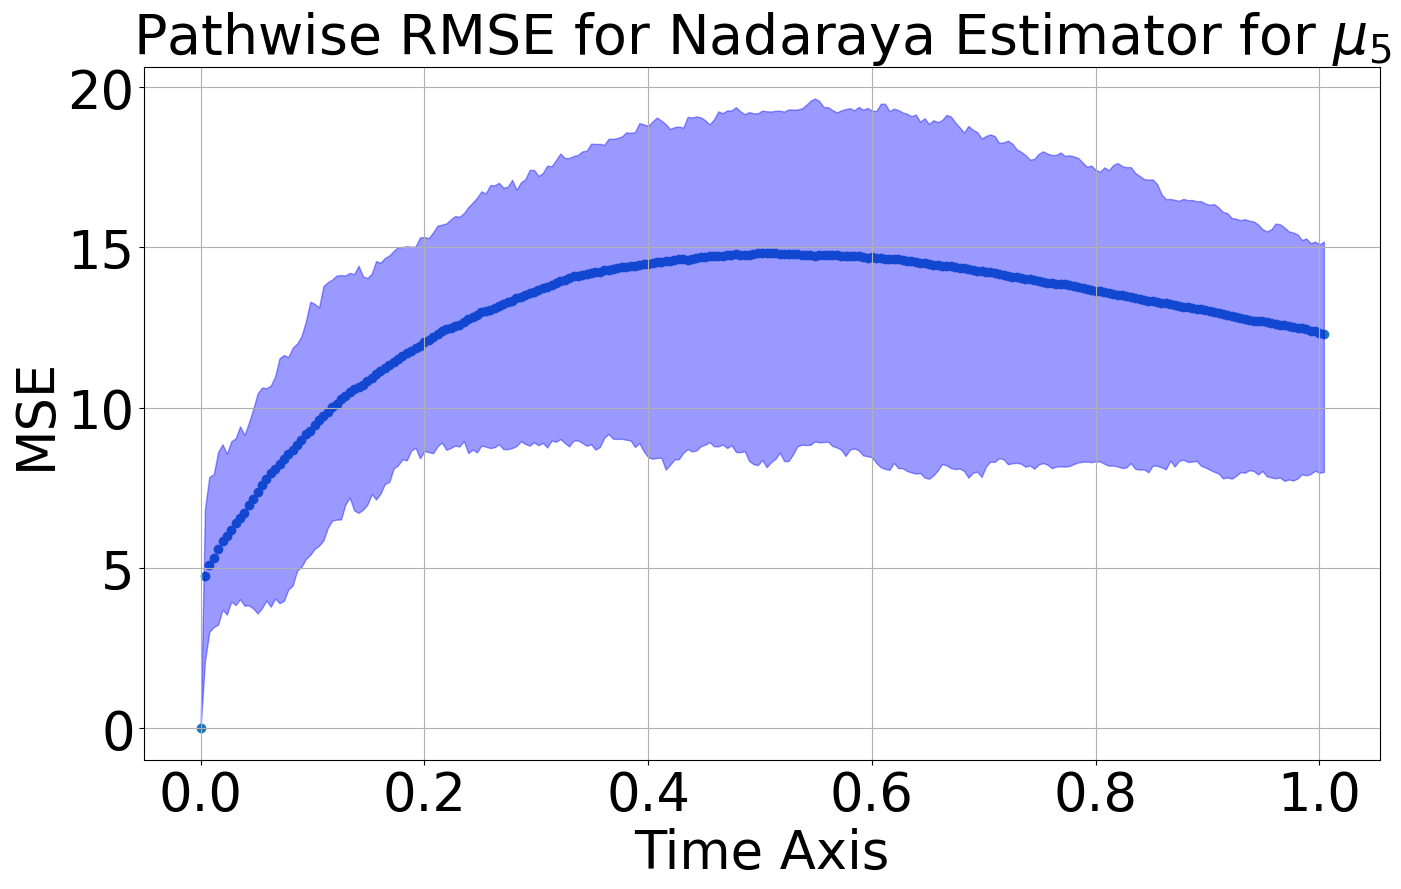

Final time cumulative MSE local-time error 12.30683221527914 with IQR ((7.997706186073532, 15.182884208664989))at bw 0.0007912 for 1.25FConst

13.119929768617947 0.0010446 12.30683221527914
12.285702811523878 0.0013793 12.30683221527914


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_5064/3039973056.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_5064/3039973056.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


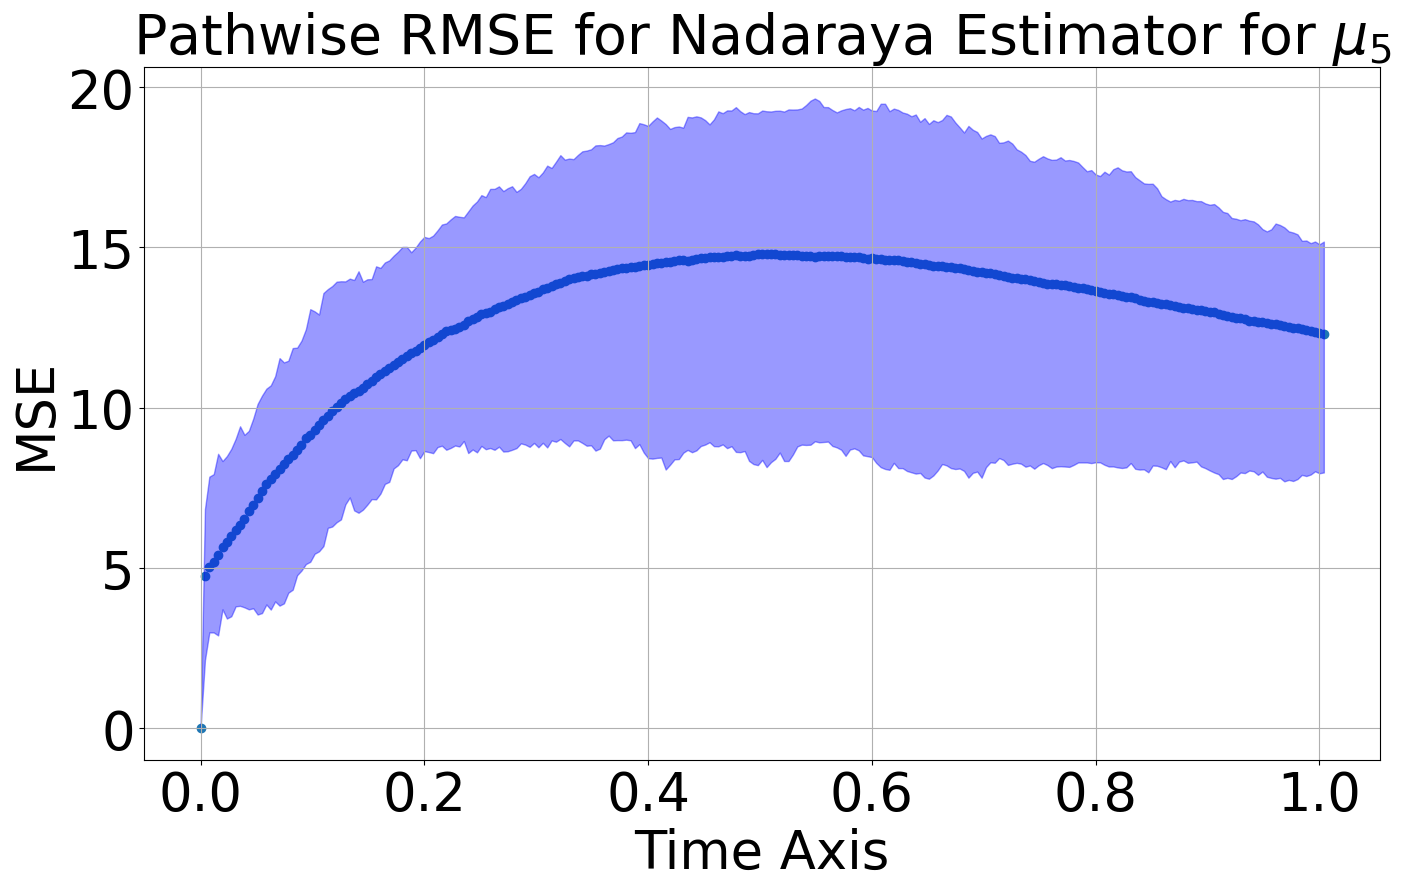

Final time cumulative MSE local-time error 12.285702811523878 with IQR ((7.980966768108117, 15.184329708265187))at bw 0.0013793 for 1.25FConst

12.255085488212003 0.0018211 12.285702811523878


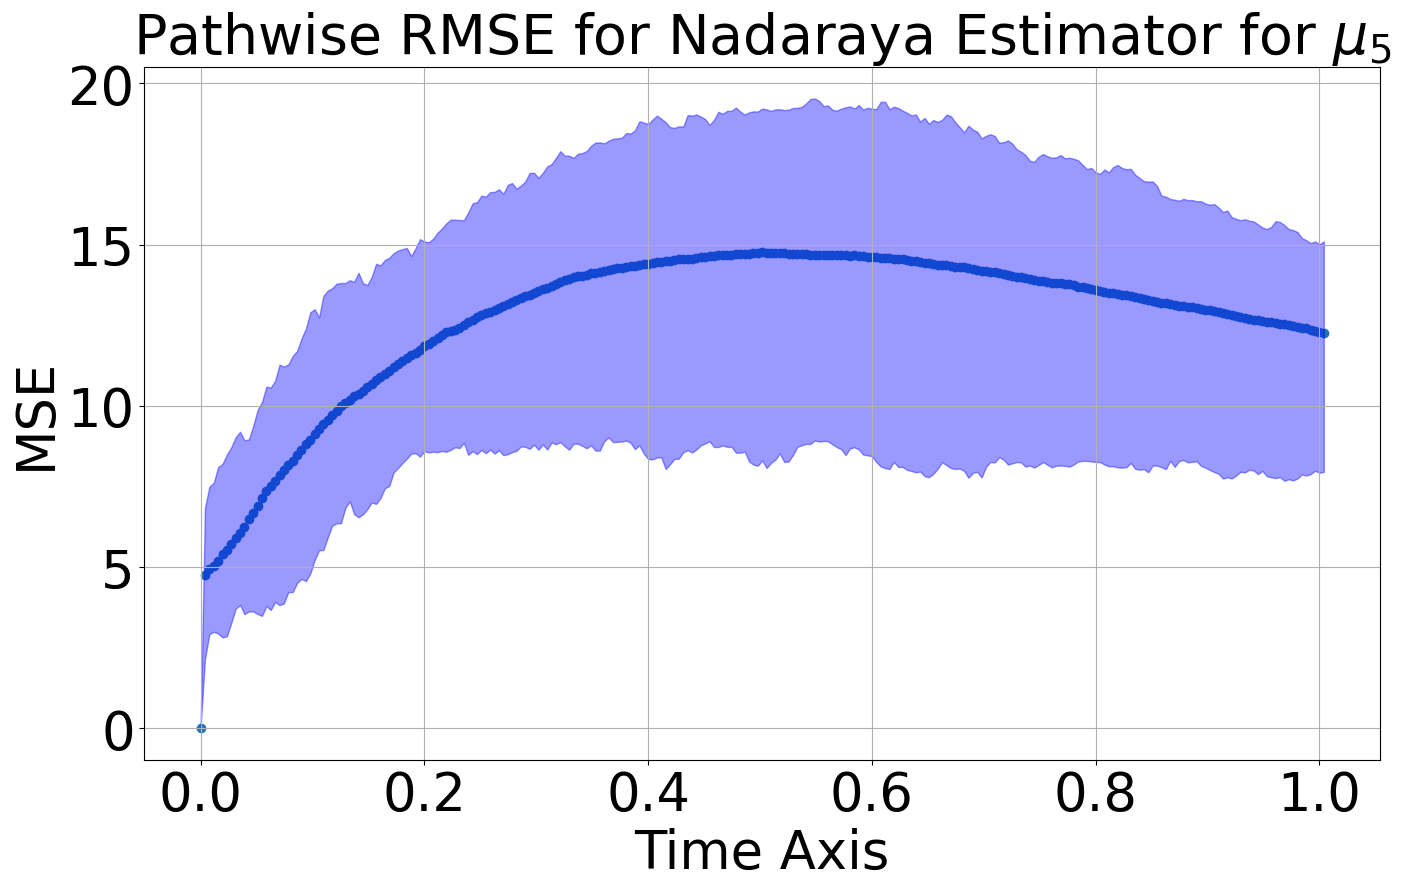

Final time cumulative MSE local-time error 12.255085488212003 with IQR ((7.951107925162701, 15.098618060153653))at bw 0.0018211 for 1.25FConst

12.198284109581174 0.0024046 12.255085488212003


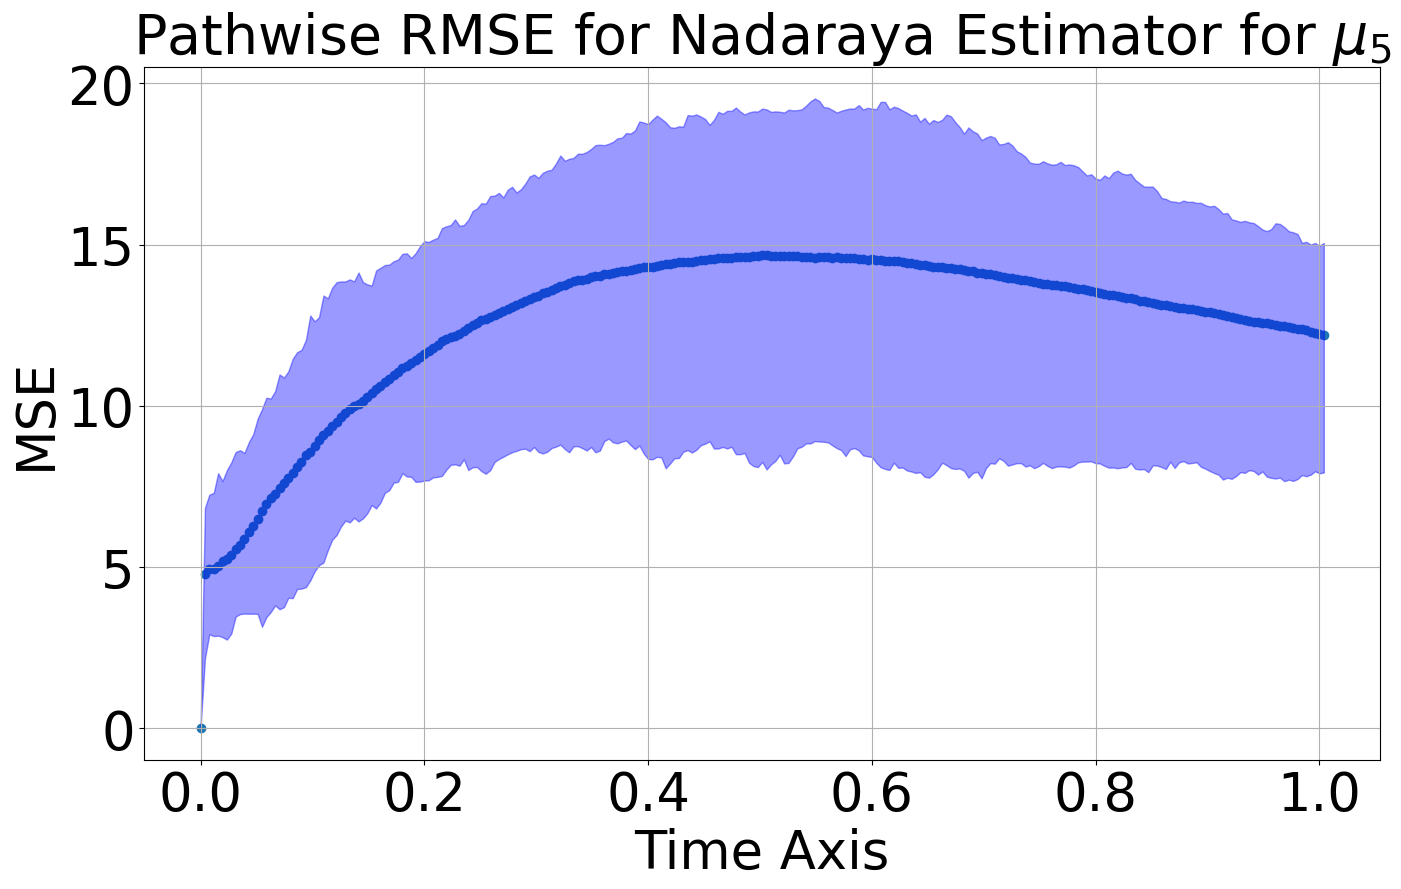

Final time cumulative MSE local-time error 12.198284109581174 with IQR ((7.933119319502776, 15.05270707305609))at bw 0.0024046 for 1.25FConst

12.101782976279347 0.0031749 12.198284109581174


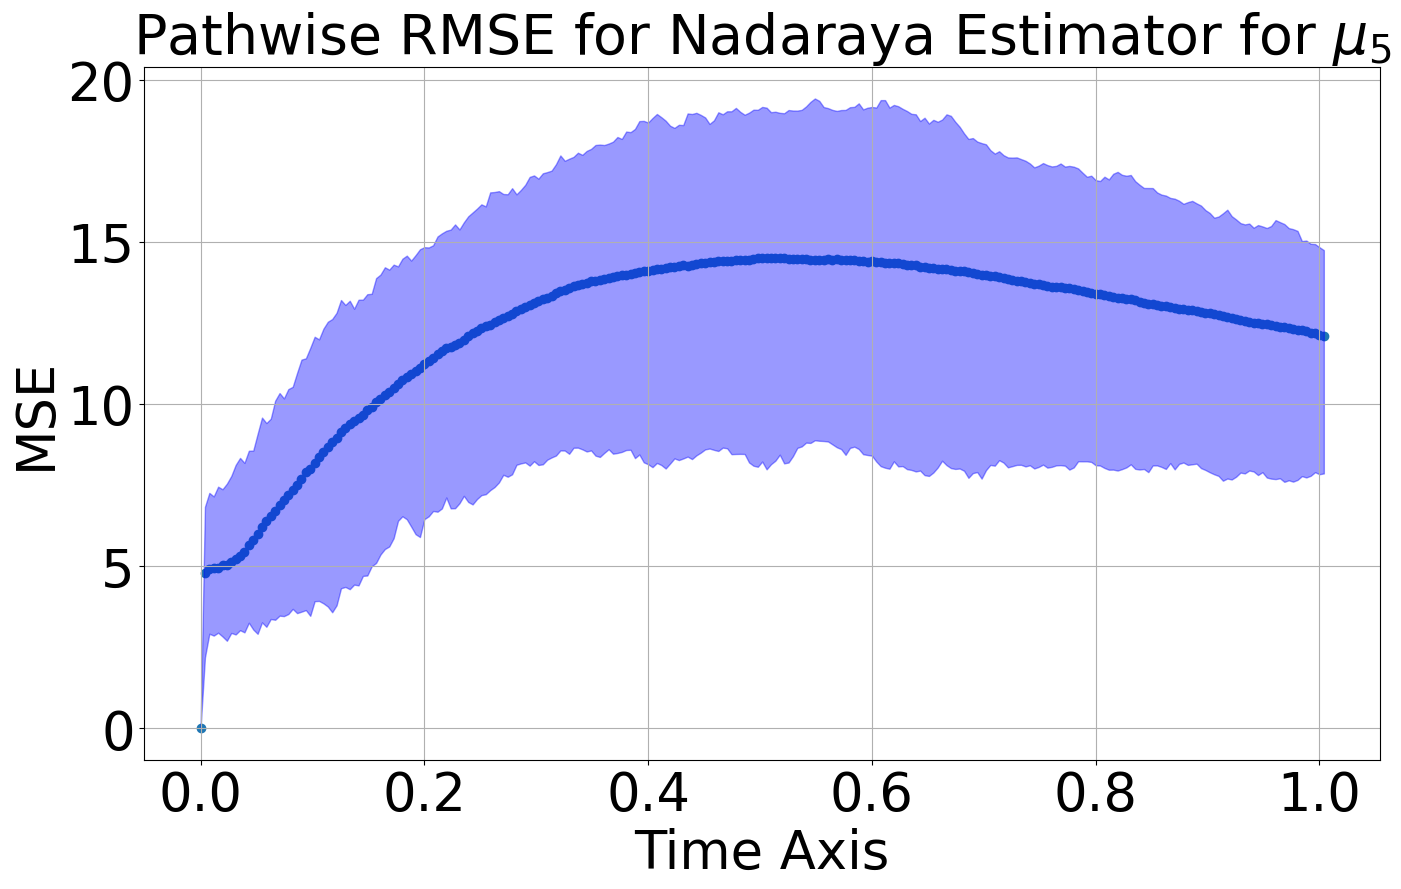

Final time cumulative MSE local-time error 12.101782976279347 with IQR ((7.858568715723761, 14.744650432649536))at bw 0.0031749 for 1.25FConst



ValueError: Cannot load file containing pickled data when allow_pickle=False

In [6]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/8DDimsNS/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [ ]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data